## domain adaptation (DANN)

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from sklearn.preprocessing import OneHotEncoder

def get_Xy(domain, path_to_folder="./vehicles/"):

    path = path_to_folder + domain
    X = []
    y = []

    for r, d, f in os.walk(path):
        for direct in d:
            if not ".ipynb_checkpoints" in direct:
                for r, d, f in os.walk(os.path.join(path , direct)):
                    for file in f:
                        path_to_image = os.path.join(r, file)
                        if not ".ipynb_checkpoints" in path_to_image:
                            image = Image.open(path_to_image)
                            image = image.resize((224, 224), Image.ANTIALIAS)
                            image = np.array(image, dtype=int)
                            X.append(image)
                            y.append(direct)
    return X, y

Xs, ys = get_Xy("source")
Xt, yt = get_Xy("target")

one = OneHotEncoder(sparse=False)
one.fit(np.array(ys).reshape(-1, 1))

ys = one.transform(np.array(ys).reshape(-1, 1))
yt = one.transform(np.array(yt).reshape(-1, 1))


print("X source shape: %s"%str(np.array(Xs).shape))
print("X target shape: %s"%str(np.array(Xt).shape))

print("Y source shape: %s"%str(np.array(ys).shape))
print("Y target shape: %s"%str(np.array(yt).shape))

C:\Users\ashkan\AppData\Local\Temp\ipykernel_10880\2220763660.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((224, 224), Image.ANTIALIAS)


X source shape: (2054, 224, 224, 3)
X target shape: (753, 224, 224, 3)
Y source shape: (2054, 4)
Y target shape: (753, 4)


In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input


resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":
        x = layer([inputs, x])
    else:
        x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

last_block.save("resnet50_last_block.hdf5")

for i in range(len(last_block.layers)):
    if last_block.layers[i].__class__.__name__ == "BatchNormalization":
        last_block.layers[i].trainable = False

In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input

Xs = first_blocks.predict(preprocess_input(np.stack(Xs)))
Xt = first_blocks.predict(preprocess_input(np.stack(Xt)))

print("X source shape: %s"%str(Xs.shape))
print("X target shape: %s"%str(Xt.shape))

24/24 [==============================] - 38s 2s/step
X source shape: (2054, 7, 7, 2048)
X target shape: (753, 7, 7, 2048)


In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm

task_network = Sequential()
task_network.add(Dense(1024, activation="relu", kernel_constraint=MaxNorm(0.5),bias_constraint=MaxNorm(0.5)))
task_network.add(Dropout(0.5))
task_network.add(Dense(1024, activation="relu",kernel_constraint=MaxNorm(0.5),bias_constraint=MaxNorm(0.5)))
task_network.add(Dropout(0.5))
task_network.add(Dense(4, activation="softmax",kernel_constraint=MaxNorm(0.5),bias_constraint=MaxNorm(0.5)))

disc_network = Sequential()
disc_network.add(Dense(1024, activation="relu", kernel_constraint=MaxNorm(0.5),bias_constraint=MaxNorm(0.5)))
disc_network.add(Dropout(0.5))
disc_network.add(Dense(1024, activation="relu",kernel_constraint=MaxNorm(0.5),bias_constraint=MaxNorm(0.5)))
disc_network.add(Dropout(0.5))
disc_network.add(Dense(4, activation="sigmoid",kernel_constraint=MaxNorm(0.5),bias_constraint=MaxNorm(0.5)))

In [8]:
from adapt.feature_based import DANN
from tensorflow.keras.optimizers import Adam

dann = DANN(encoder = last_block, 
            task = task_network,
            discriminator= disc_network,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            optimizer=Adam(0.001),
            optimizer_enc=Adam(0.0001),
            optimizer_disc=Adam(0.0001))

dann.fit(X=Xs[:-1], y=ys[:-1], Xt=Xt, epochs=200, batch_size=32, validation_data=(Xt, yt))

Epoch 1/200
65/65 [==============================] - 50s 736ms/step - loss: 0.6682 - acc: 0.7139 - disc_loss: 0.8514 - disc_acc: 0.3897 - val_loss: 1.5486 - val_acc: 0.4037
Epoch 2/200
65/65 [==============================] - 47s 721ms/step - loss: 0.2636 - acc: 0.8918 - disc_loss: 0.1643 - disc_acc: 0.2339 - val_loss: 1.4493 - val_acc: 0.5458
Epoch 3/200
65/65 [==============================] - 47s 725ms/step - loss: 0.1407 - acc: 0.9466 - disc_loss: 0.0887 - disc_acc: 0.2417 - val_loss: 2.1919 - val_acc: 0.4807
Epoch 4/200
65/65 [==============================] - 47s 720ms/step - loss: 0.0843 - acc: 0.9726 - disc_loss: 0.0893 - disc_acc: 0.2680 - val_loss: 2.2336 - val_acc: 0.5206
Epoch 5/200
65/65 [==============================] - 47s 719ms/step - loss: 0.0743 - acc: 0.9764 - disc_loss: 0.1183 - disc_acc: 0.2760 - val_loss: 2.5061 - val_acc: 0.4874
Epoch 6/200
65/65 [==============================] - 47s 720ms/step - loss: 0.1923 - acc: 0.9716 - disc_loss: 1.3975 - disc_acc: 0.2623

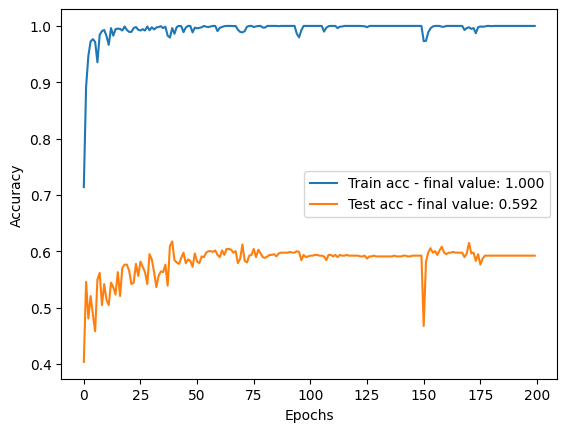

In [9]:
acc = dann.history.history["acc"]
val_acc = dann.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

65/65 [==============================] - 3s 52ms/step


c:\Users\ashkan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\ashkan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


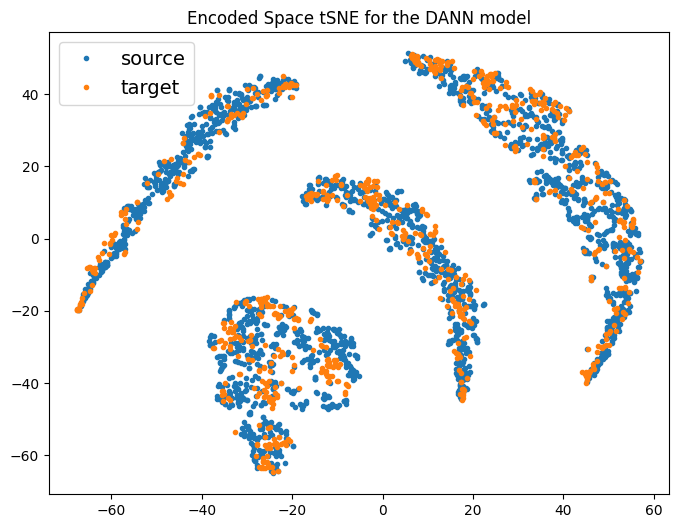

In [10]:
from sklearn.manifold import TSNE

Xs_enc = dann.transform(Xs)
Xt_enc = dann.transform(Xt)

np.random.seed(0)
X_ = np.concatenate((Xs_enc, Xt_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(Xs), 0], X_tsne[:len(Xs), 1], '.', label="source")
plt.plot(X_tsne[len(Xs):, 0], X_tsne[len(Xs):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the DANN model")
plt.show()